In [1]:
import pickle as pkl
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Get random sample of Gaia data for CMD from AXS

To do this
https://github.com/dirac-institute/ZTF_Boyajian/blob/master/dipper_detection_new.ipynb

In [6]:
import getpass
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import axs
import pyspark.sql.functions as sparkfunc

ModuleNotFoundError: No module named 'axs'

In [ ]:
def spark_start(local_dir):
    from pyspark.sql import SparkSession
    
    spark = (
            SparkSession.builder
            .appName("LSD2")
            .config("spark.sql.warehouse.dir", local_dir)
            .config('spark.master', "local[20]")
            .config('spark.driver.memory', '8G') # 128
            .config('spark.local.dir', local_dir)
            .config('spark.memory.offHeap.enabled', 'true')
            .config('spark.memory.offHeap.size', '4G') # 256
            .config("spark.sql.execution.arrow.enabled", "true")
            .config("spark.driver.maxResultSize", "6G")
            .config("spark.driver.extraJavaOptions", f"-Dderby.system.home={local_dir}")
            .config("spark.port.maxRetries", 25)
            .enableHiveSupport()
            .getOrCreate()
            
    )   

    return spark

username = getpass.getuser()
spark_session = spark_start(f"/epyc/users/{username}/spark-tmp/")

catalog = axs.AxsCatalog(spark_session)

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34065)
Traceback (most recent call last):
  File "/epyc/opt/spark-axs/python/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/epyc/opt/spark-axs/python/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34065)
Traceback (most recent call last):
  File "/epyc/opt/spark-axs/python/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/epyc/op

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34065)
Traceback (most recent call last):
  File "/epyc/opt/spark-axs/python/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/epyc/opt/spark-axs/python/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34065)
Traceback (most recent call last):
  File "/epyc/opt/spark-axs/python/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/epyc/op

# Do this with Gaia instead

In [2]:
from astroquery.gaia import Gaia

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


## Bin on the server

Observed CMD diagram from https://www.cosmos.esa.int/web/gaia-users/archive/writing-queries

In [3]:
query_template = """SELECT bp_rp_index / 40 AS bp_rp, g_abs_index / 10 AS g_abs, n FROM (
SELECT
    floor(bp_rp * 40) AS bp_rp_index,
    floor((phot_g_mean_mag + 5 * log10(parallax) - 10) * 10) AS g_abs_index,
    count(*) AS n
FROM gaiadr2.gaia_source
WHERE parallax_over_error > 5
AND a_g_val IS NOT NULL
AND random_index < {}
GROUP BY bp_rp_index, g_abs_index
) AS subquery
"""

In [4]:
job_small = Gaia.launch_job_async(query_template.format(80000))
results_small = job_small.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


In [5]:
job_large = Gaia.launch_job_async(query_template.format(800000))
results_large = job_large.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


## We'll do the binning

In [3]:
query2_template = """SELECT bp_rp, phot_g_mean_mag+5*log10(parallax)-10 AS g_abs, parallax, ra, dec 
FROM gaiadr2.gaia_source
WHERE parallax_over_error > 5
AND a_g_val IS NOT NULL
AND random_index < {}
"""

In [4]:
job2_small = Gaia.launch_job_async(query2_template.format(80000))
results2_small = job2_small.get_results()

KeyboardInterrupt: 

In [ ]:
job2_large = Gaia.launch_job_async(query2_template.format(800000))
results2_large = job2_large.get_results()

In [ ]:
bp_rp_count = int((max(r['bp_rp']) - min(r['bp_rp']) + 1) * 40)
g_abs_count = int((max(r['g_abs']) - min(r['g_abs']) + 1) * 10)

bp_rp_index = np.round((r['bp_rp'] - min(r['bp_rp'])) * 40).astype(int)
g_abs_index = np.round((r['g_abs'] - min(r['g_abs'])) * 10).astype(int)

image = np.zeros((g_abs_count, bp_rp_count))
image[g_abs_index, bp_rp_index] = r['n'].T

plt.figure(figsize=(30, 20))
plt.imshow(np.log10(image));

In [6]:
def make_background_cmd(r, ax, **kwargs):
    bp_rp_count = int((max(r['bp_rp']) - min(r['bp_rp']) + 1) * 40)
    g_abs_count = int((max(r['g_abs']) - min(r['g_abs']) + 1) * 10)

    bp_rp_index = np.round((r['bp_rp'] - min(r['bp_rp'])) * 40).astype(int)
    g_abs_index = np.round((r['g_abs'] - min(r['g_abs'])) * 10).astype(int)

    image = np.zeros((g_abs_count, bp_rp_count))
    image[ g_abs_index, bp_rp_index] = r['n'].T
    im = ax.imshow(np.log10(image), extent=[min(r['bp_rp']), max(r['bp_rp']), max(r['g_abs']), min(r['g_abs'])], **kwargs);

    ax.set_ylabel('Absolute G Mag')
    ax.set_xlabel('bp-rp')
    return im

# Extinction

By definition:  
$R_v = \frac{A_v}{E(B-V)}$  
We can use the A_lambda_over_Av values below from the Parsec group and the E(B-V) values from ? to get $A_\lambda$  
$A_\lambda = E(B-V) \times \frac{A_\lambda}{A_V}\times R_V$ Where $R_V = 3.1$

In [7]:
# From Parsec
# Values for G2V star using Cardelli+ 1989 and O'DOnnel 1994 extinction curves with R_v = 3.1
#wave_eff_G = 6390.21
#omega_eff_G = 4416
A_G_over_Av = 0.83627

#wave_eff_G_BP = 5182.58
#omega_eff_G_BP = 2617
A_BP_over_Av = 1.08337

#wave_eff_R_BP = 7825.08
#omega_eff_R_BP = 2863
A_RP_over_Av = 0.63439

## DF with A and B candidates

In [8]:
pkl_df = pkl.load(open('/epyc/data/boyajian/dippers_data_v2.pkl', 'rb'))
pkl_df.head()

,ps1_objid,sample,ra,dec,mean_mag_g,mean_mag_r,mean_mag_i,ra_stddev,dec_stddev,ps1_gMeanPSFMag,...,dip_outside_window_med_magerr,dip_noise_ratio,dip_rms_ratio,dip_diff_sum,dip_diff_ratio,dip_max_gap,dip_max_gap_ratio,dip_frac_10,dip_frac_20,dip_frac_50
0,168433257951352509,A,325.795112,50.359852,18.667411,17.087635,16.300364,0.000035,0.000021,18.417801,...,0.040105,2.350524,5.343059,4.394930,2.047220,6.952014,0.145088,0.143678,0.022989,0.000000
1,179030313136257708,A,31.313617,59.197535,19.398446,18.161548,NaN,0.000059,0.000036,19.286900,...,0.030382,1.131410,8.579913,3.465202,1.822246,2.094282,0.149072,0.004878,0.004878,0.004878
2,173260619709112041,A,61.970893,54.384495,15.723220,14.796842,NaN,0.000024,0.000018,15.655600,...,0.014521,1.020284,12.657307,1.312467,1.741225,1.995949,0.110139,0.000000,0.000000,0.000000
3,126442877393679193,A,287.739339,15.373873,20.204753,18.315664,17.133254,0.000049,0.000031,20.006599,...,0.035541,2.636593,7.509860,7.677393,1.798500,1.966157,0.129999,0.231029,0.042159,0.000000
4,100582959343631974,A,295.934355,-6.182024,17.467897,16.621087,NaN,0.000028,0.000026,17.381599,...,0.026121,1.566794,10.535548,1.146963,1.298975,6.020996,0.333333,0.062500,0.000000,0.000000


## Read in Cross match files

In [9]:
gaia_source_df = pd.read_parquet('/epyc/data/boyajian/wtf_aug2020_dip_candidates_x_gaia_source_edr3')
gaia_source_df.columns
gaia_source_df.head()

,ps1_objid,source_id,ruwe,bp_rp,bp_g,g_rp,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_mag,phot_bp_mean_flux,...,phot_rp_mean_flux_error,phot_rp_mean_mag,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error
0,94362690352503521,4151665613406613504,1.084682,3.392249,2.073599,1.318650,59699.374860,133.993700,13.747442,6412.103582,...,458.918300,12.428792,0.049135,0.029025,1.692814,9.126816,-0.202643,0.031038,-9.124566,0.021297
1,102792824349146924,4255271185341568768,1.059162,2.131899,1.110409,1.021490,798.873467,1.740153,18.431171,208.345971,...,12.265520,17.409681,0.243178,0.200626,1.212096,4.169343,-1.502534,0.201689,-3.889192,0.165278
2,156601035871513395,950655929677107712,1.107905,3.686758,2.278308,1.408450,523612.181211,4848.080600,11.389843,46575.375555,...,20163.545000,9.981393,0.092483,0.052256,1.769814,4.060296,1.186285,0.046603,-3.883134,0.044009
3,191931269081849923,1097464719378492800,1.056467,0.789890,0.313609,0.476281,52224.366490,8.327744,13.892684,28372.635724,...,23.752308,13.416403,1.375509,0.013897,98.975740,11.214291,-10.304863,0.011989,-4.423812,0.014859
4,111492860979335175,4268567265914325760,0.983518,3.037911,1.775791,1.262119,842.131504,1.879299,18.373917,118.996407,...,11.367281,17.111797,-0.024850,0.186990,-0.132895,7.098120,-3.839143,0.202331,-5.970284,0.149248


### Green Distances and reddening

E = E(B-V)  
dm = distance modulus  
16 = mean-1$\sigma$  
50 = mean  
84 = mean+1$\sigma$

In [10]:
green_df = pd.read_parquet('/epyc/data/boyajian/wtf_aug2020_dip_candidates_x_green19_stellar_params')
green_df.head()

,ps1_objid,dm_16,E_16,Mr_16,FeH_16,dm_50,E_50,Mr_50,FeH_50,dm_84,E_84,Mr_84,FeH_84,chisq,gaia_id
0,94362690352503521,11.275535,1.565869,-1.000000,-0.75,11.336248,1.580092,-1.000,-0.525,11.377617,1.597467,-0.950000,-0.35,19.495815,4151665613406613504
1,102792824349146924,12.372326,0.920623,1.925815,-0.65,13.282516,0.996778,2.675,-0.400,14.238860,1.105575,3.324185,-0.15,0.215834,4255271185341568768
2,111492860979335175,14.178335,1.455591,-0.150000,-0.65,14.729681,1.494254,0.300,-0.450,15.187395,1.535519,0.750000,-0.25,0.009404,0
3,137850841680121583,12.883073,0.754520,-0.700000,-0.75,13.352509,0.780381,-0.350,-0.550,13.745750,0.810732,0.050000,-0.35,1.731202,3440769017465094400
4,91582752294995270,11.498332,1.072945,0.000000,-0.70,11.708506,1.095990,0.200,-0.500,11.960686,1.115744,0.350000,-0.30,142.561569,4152421080966024704


### Gaia Distances

In [11]:
gaia_dist_df = pd.read_parquet('/epyc/data/boyajian/wtf_aug2020_dip_candidates_x_gaia_edr3_distances')
gaia_dist_df.head()

,ps1_objid,source_id,r_med_geo,r_lo_geo,r_hi_geo,r_med_photogeo,r_lo_photogeo,r_hi_photogeo,flag
0,94362690352503521,4151665613406613504,8082.282710,6528.992190,10042.92480,6778.116700,5999.020510,7678.308110,10033
1,102792824349146924,4255271185341568768,5927.677250,3682.042240,9454.38770,4220.221680,3066.974120,6016.558110,10033
2,156601035871513395,950655929677107712,5957.758790,4843.100100,7360.06445,6164.116700,4819.110840,8932.376950,10022
3,191931269081849923,1097464719378492800,711.026001,703.748535,718.46460,711.767944,705.468994,718.537537,10033
4,111492860979335175,4268567265914325760,6945.243160,4411.955570,10387.13480,6404.486820,3725.717530,8577.027340,10033


## Join DataFrames to get info for just A and B sample

In [12]:
sample_df = gaia_source_df.merge(pkl_df, on='ps1_objid', how='inner')
sample_df = sample_df.merge(green_df, on='ps1_objid', how='inner')
sample_df.columns

Index(['ps1_objid', 'source_id', 'ruwe', 'bp_rp', 'bp_g', 'g_rp',
       'phot_g_mean_flux', 'phot_g_mean_flux_error', 'phot_g_mean_mag',
       'phot_bp_mean_flux',
       ...
       'dm_50', 'E_50', 'Mr_50', 'FeH_50', 'dm_84', 'E_84', 'Mr_84', 'FeH_84',
       'chisq', 'gaia_id'],
      dtype='object', length=129)

### Plot apparent mags

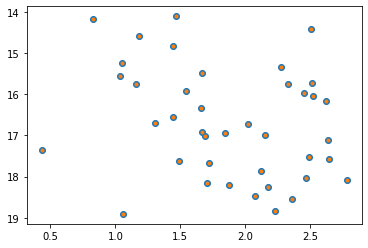

In [13]:
fig, ax = plt.subplots(1,1)
ax.plot(sample_df['phot_bp_mean_mag']-sample_df['phot_rp_mean_mag'], 
        sample_df['phot_g_mean_mag'], 'o')
ax.plot(sample_df['bp_rp'], 
        sample_df['phot_g_mean_mag'], '.')
ax.invert_yaxis()

### Plot absolute mags without extinction

In [14]:
bp_abs_mag_no_ext_corr = sample_df['phot_bp_mean_mag'] - sample_df['dm_50']
rp_abs_mag_no_ext_corr = sample_df['phot_rp_mean_mag'] - sample_df['dm_50']
g_abs_mag_no_ext_corr = sample_df['phot_g_mean_mag'] - sample_df['dm_50']

(12.5, -6)

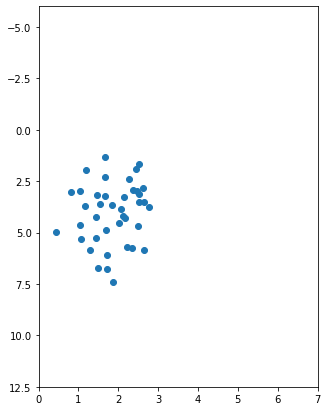

In [15]:
fig, ax = plt.subplots(1,1, figsize=(5, 7))
ax.plot(bp_abs_mag_no_ext_corr-rp_abs_mag_no_ext_corr, 
        g_abs_mag_no_ext_corr, 'o')
ax.set_xlim(0, 7)
ax.set_ylim(12.5, -6)

## Plot absolute mags with extinction correction

In [16]:
sample_df['A_G' ]= sample_df['E_50']*A_G_over_Av*3.1
sample_df['A_bp'] = sample_df['E_50']*A_BP_over_Av*3.1
sample_df['A_rp'] = sample_df['E_50']*A_RP_over_Av*3.1

### Check that extinction values are all positive

In [17]:
print(sample_df['A_rp'][sample_df['A_G']<0])
print(sample_df['E_50'][sample_df['A_bp']<0])
print(sample_df[sample_df['A_rp']<0])


0   -0.998176
Name: A_rp, dtype: float32
0   -0.507562
Name: E_50, dtype: float32
            ps1_objid            source_id      ruwe    bp_rp      bp_g  \
0  139092829523868897  4534934128217298176  1.002928  0.43717  0.033081   

       g_rp  phot_g_mean_flux  phot_g_mean_flux_error  phot_g_mean_mag  \
0  0.404089        2150.75198                50.34192         17.35589   

   phot_bp_mean_flux  ...  FeH_50      dm_84      E_84     Mr_84  FeH_84  \
0        1512.963216  ...   -0.75  12.538801 -0.473516  7.074185   -0.55   

        chisq              gaia_id       A_G     A_bp      A_rp  
0  234.067535  4534934128217298176 -1.315822 -1.70462 -0.998176  

[1 rows x 132 columns]


#### they aren't - check to see if you can identify outliers

#### Look at just the star with negative extinction

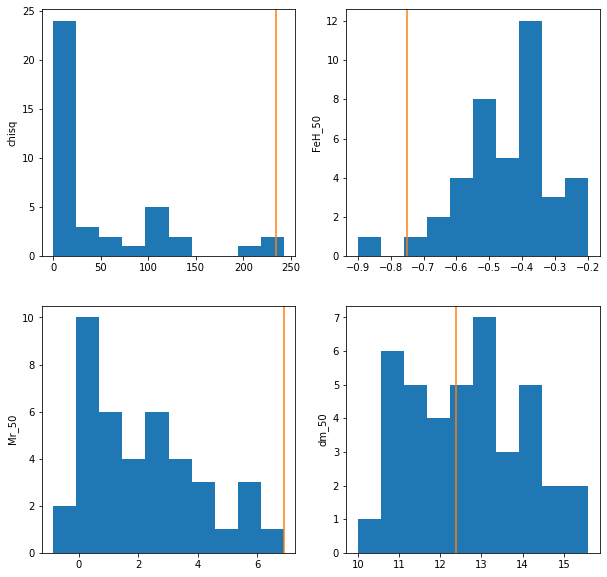

In [18]:
marked_indx = sample_df['A_bp']<0

fig, ax_list = plt.subplots(2,2, figsize=[10,10])
ax_list[0,0].set_ylabel('chisq')
ax_list[0,0].hist(sample_df['chisq'])
ax_list[0,0].axvline(sample_df['chisq'][marked_indx][0], color='C1')

ax_list[0,1].set_ylabel('FeH_50')
ax_list[0,1].hist(sample_df['FeH_50'])
ax_list[0,1].axvline(sample_df['FeH_50'][marked_indx][0], color='C1')

ax_list[1,0].set_ylabel('Mr_50')
ax_list[1,0].hist(sample_df['Mr_50'])
ax_list[1,0].axvline(sample_df['Mr_50'][marked_indx][0], color='C1')

ax_list[1,1].set_ylabel('dm_50')
ax_list[1,1].hist(sample_df['dm_50'])
ax_list[1,1].axvline(sample_df['dm_50'][marked_indx][0], color='C1')

#### Look at all stars with high chisq

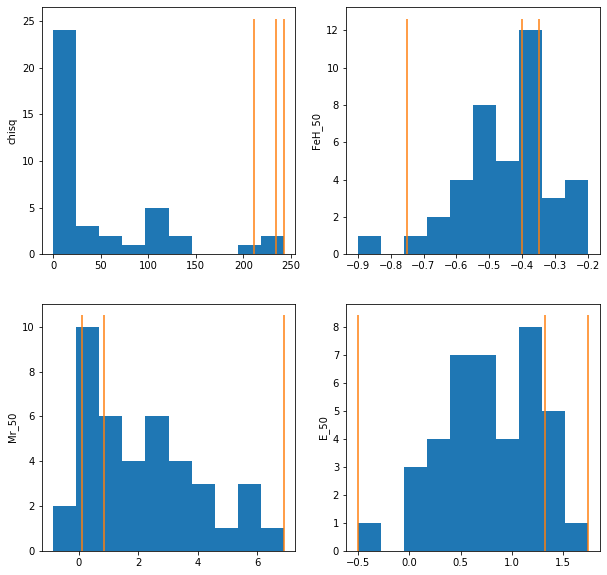

In [19]:
marked_indx = sample_df['chisq']>150

fig, ax_list = plt.subplots(2,2, figsize=[10,10])
ax_list[0,0].set_ylabel('chisq')
ax_list[0,0].hist(sample_df['chisq'])
ax_list[0,0].vlines(sample_df['chisq'][marked_indx].to_numpy(), color='C1', *ax_list[0,0].get_ylim())

ax_list[0,1].set_ylabel('FeH_50')
ax_list[0,1].hist(sample_df['FeH_50'])
ax_list[0,1].vlines(sample_df['FeH_50'][marked_indx].to_numpy(), color='C1', *ax_list[0,1].get_ylim())

ax_list[1,0].set_ylabel('Mr_50')
ax_list[1,0].hist(sample_df['Mr_50'])
ax_list[1,0].vlines(sample_df['Mr_50'][marked_indx].to_numpy(), color='C1', *ax_list[1,0].get_ylim())

ax_list[1,1].set_ylabel('E_50')
ax_list[1,1].hist(sample_df['E_50'])
ax_list[1,1].vlines(sample_df['E_50'][marked_indx].to_numpy(), color='C1', *ax_list[1,1].get_ylim())

In [20]:
sample_df['chisq'][marked_indx].to_numpy()

array([234.06754, 242.62723, 210.88402], dtype=float32)

In [21]:
bp_abs_mag = sample_df['phot_bp_mean_mag'] - sample_df['dm_50'] - sample_df['A_bp']
rp_abs_mag = sample_df['phot_rp_mean_mag'] - sample_df['dm_50'] - sample_df['A_rp']
g_abs_mag = sample_df['phot_g_mean_mag'] - sample_df['dm_50'] - sample_df['A_G']


(12.5, -6)

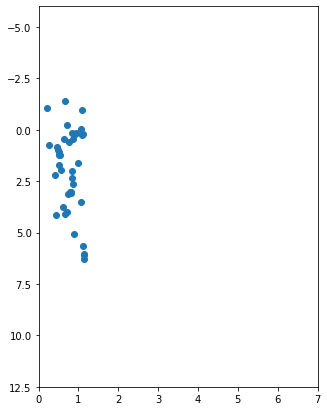

In [22]:
fig, ax = plt.subplots(1,1, figsize=(5, 7))
ax.plot(bp_abs_mag-rp_abs_mag, 
        g_abs_mag, 'o')
ax.set_xlim(0, 7)
ax.set_ylim(12.5, -6)

In [23]:
grouped_sample_df = sample_df.groupby('sample')

In [24]:
#Add Boyajian's star
boyajian_bp_rp = 0.7817 # mag
boyajian_phot_g_mean_mag = 11.7626 # mag
boyajian_parallax = 2.2185 # mas

/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


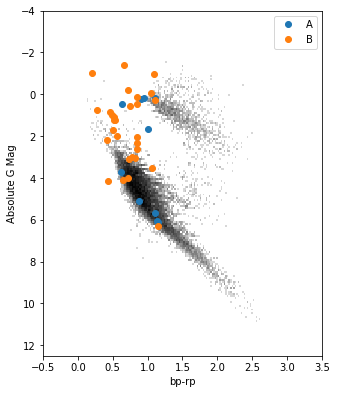

In [25]:
fig, ax = plt.subplots(1,1, figsize=(5,7))
make_background_cmd(results_large, ax, aspect=0.3, cmap='binary')
for indx, sample in grouped_sample_df:
    bp_abs_mag = sample['phot_bp_mean_mag'] - sample['dm_50'] - sample['A_bp']
    rp_abs_mag = sample['phot_rp_mean_mag'] - sample['dm_50'] - sample['A_rp']
    g_abs_mag = sample['phot_g_mean_mag'] - sample['dm_50'] - sample['A_G']
    ax.plot(bp_abs_mag-rp_abs_mag, g_abs_mag, 'o', label=indx)
    
ax.set_xlim(-0.5, 3.5)
ax.set_ylim(12.5, -4)
plt.legend()
plt.savefig('/astro/users/bostroem/dippers/figures/sample_gaia_cmd.pdf')

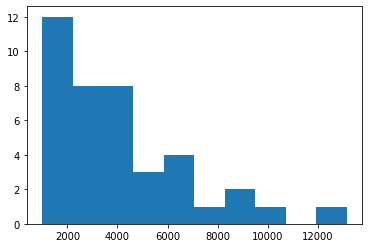

In [332]:
plt.hist(10**((sample_df['dm_50']+5)/5));

/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


(12.5, -4)

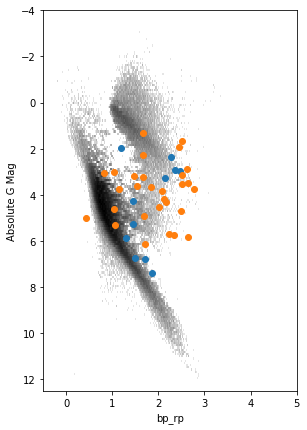

In [250]:

fig, ax = plt.subplots(1,1, figsize=(5, 7))
make_background_cmd(results, ax, aspect=0.5, cmap='binary')
for indx, sample in grouped_sample_df:
    bp_abs_mag = sample['phot_bp_mean_mag'] - sample['dm_50']
    rp_abs_mag = sample['phot_rp_mean_mag'] - sample['dm_50']
    g_abs_mag = sample['phot_g_mean_mag'] - sample['dm_50']
    ax.plot(bp_abs_mag-rp_abs_mag, g_abs_mag, 'o', label=indx)
    
ax.set_xlim(-0.5, 5)
ax.set_ylim(12.5, -4)

/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


(12.5, -4)

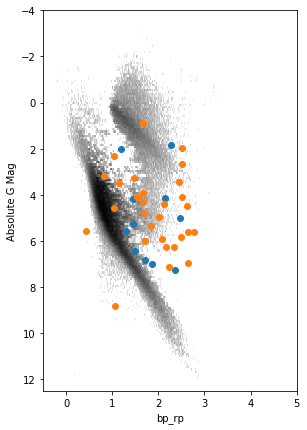

In [252]:
fig, ax = plt.subplots(1,1, figsize=(5, 7))
im = make_background_cmd(results, ax, aspect=0.5, cmap='binary')
for indx, sample in grouped_sample_df:
    bp_abs_mag = sample['phot_bp_mean_mag'] + 5 * np.log10(sample['parallax']) -10
    rp_abs_mag = sample['phot_rp_mean_mag'] + 5 * np.log10(sample['parallax']) -10 
    g_abs_mag = sample['phot_g_mean_mag'] + 5 * np.log10(sample['parallax']) -10 
    ax.plot(bp_abs_mag-rp_abs_mag, g_abs_mag, 'o', label=indx)
    
ax.set_xlim(-0.5, 5)
ax.set_ylim(12.5, -4)

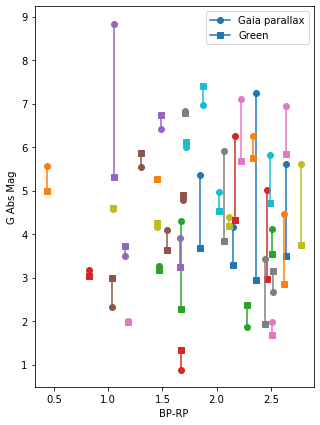

In [264]:
fig, ax = plt.subplots(1,1, figsize=(5, 7))

for indx, sample in grouped_sample_df:
    bp_abs_mag = sample['phot_bp_mean_mag'] - sample['dm_50']
    rp_abs_mag = sample['phot_rp_mean_mag'] - sample['dm_50']
    g_abs_mag = sample['phot_g_mean_mag'] - sample['dm_50']
    bp_rp = bp_abs_mag - rp_abs_mag
    
    bp_abs_mag_gaia = sample['phot_bp_mean_mag'] + 5 * np.log10(sample['parallax']) -10
    rp_abs_mag_gaia = sample['phot_rp_mean_mag'] + 5 * np.log10(sample['parallax']) -10 
    g_abs_mag_gaia = sample['phot_g_mean_mag'] + 5 * np.log10(sample['parallax']) -10 
    bp_rp_gaia = bp_abs_mag_gaia - rp_abs_mag_gaia

    for icolor_green, imag_green, icolor_gaia, imag_gaia in zip(bp_rp, g_abs_mag, bp_rp_gaia, g_abs_mag_gaia):
        l, = plt.plot([icolor_green, icolor_gaia],[imag_green, imag_gaia], marker='o', label='Gaia parallax')
        l2, = plt.plot(icolor_green, imag_green, marker='s', color=l.get_color(), label='Green')
ax.set_xlabel('BP-RP')
ax.set_ylabel('G Abs Mag')
ax.legend([l.get_label(), l2.get_label()])

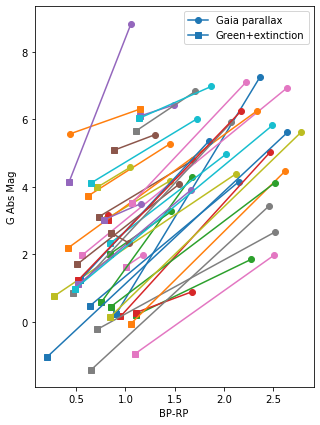

In [295]:
fig, ax = plt.subplots(1,1, figsize=(5, 7))

for indx, sample in grouped_sample_df:
    bp_abs_mag = sample['phot_bp_mean_mag'] - sample['dm_50']-sample['A_bp']
    rp_abs_mag = sample['phot_rp_mean_mag'] - sample['dm_50']-sample['A_rp']
    g_abs_mag = sample['phot_g_mean_mag'] - sample['dm_50']-sample['A_G']
    bp_rp = bp_abs_mag - rp_abs_mag
    
    bp_abs_mag_gaia = sample['phot_bp_mean_mag'] + 5 * np.log10(sample['parallax']) -10
    rp_abs_mag_gaia = sample['phot_rp_mean_mag'] + 5 * np.log10(sample['parallax']) -10 
    g_abs_mag_gaia = sample['phot_g_mean_mag'] + 5 * np.log10(sample['parallax']) -10 
    bp_rp_gaia = bp_abs_mag_gaia - rp_abs_mag_gaia

    for icolor_green, imag_green, icolor_gaia, imag_gaia in zip(bp_rp, g_abs_mag, bp_rp_gaia, g_abs_mag_gaia):
        l, = plt.plot([icolor_green, icolor_gaia],[imag_green, imag_gaia], marker='o', label='Gaia parallax')
        l2, = plt.plot(icolor_green, imag_green, marker='s', color=l.get_color(), label='Green+extinction')
ax.set_xlabel('BP-RP')
ax.set_ylabel('G Abs Mag')
ax.legend([l.get_label(), l2.get_label()])

# Distance Histograms

In [361]:
results2_large['dist_mod'] = -(5 * np.log10(results2_large['parallax']) -10)

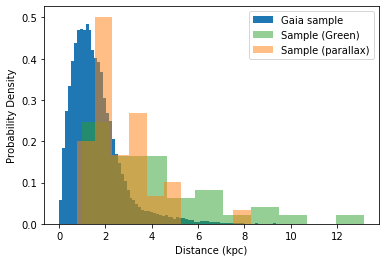

In [378]:
fig, ax1 = plt.subplots(1,1)
ax1.hist(10**((results2_large['dist_mod']+5)/5)/1000, bins=100, density=True, label='Gaia sample');
#ax2 = ax1.twinx()
ax1.hist(10**((sample_df['dm_50']    +5)/5)/1000, density=True, color='C2', alpha=0.5, bins=10, label='Sample (Green)');

ax1.hist(10**(((-(5 * np.log10(sample_df['parallax']) -10))    +5)/5)/1000, density=True, color='C1', alpha=0.5, bins=10, label='Sample (parallax)');

ax1.set_ylabel('Probability Density')
ax1.set_xlabel('Distance (kpc)')
plt.legend()

In [348]:
max(results2_large['dist_mod'])

-0.15785487644477314

In [349]:
max(sample_df['dm_50'])

15.59305477142334

In [358]:
min(sample_df['parallax']), max(sample_df['parallax'])

(0.12099498388268946, 1.2612284287035613)

In [357]:
min(results2_large['parallax']), max(results2_large['parallax'])

(0.0791428902597886, 92.9884534428276)

In [359]:
min(sample_df['dm_50']), max(sample_df['dm_50'])

(9.989612579345703, 15.59305477142334)

In [360]:
min(results2_large['dist_mod']), max(results2_large['dist_mod'])

(-15.507940467787591, -0.15785487644477314)